# DEG Analays

Deseq2 Code from Decoupler tutorial: [link](https://decoupler.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html#loading-packages)

EdgeR code from: [link](https://www.sc-best-practices.org/conditions/differential_gene_expression.html#pseudobulk)

Installation EdgeR in R (in R terminal):
```bash
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    
BiocManager::install("edgeR")
```

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pydeseq2.dds import DeseqDataSet, DefaultInference
# from pydeseq2.ds import DeseqStats

import decoupler as dc
import pertpy as pt
# ATTENTION: need for perpty of running jupternotbook
%matplotlib inline


import os
from pathlib import Path

from utils import preprocessing
from utils import DEG


BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
ADATA_PATH = f"{BASE_PATH}/adata_for_DEG/adata_for_DEG_slidetag.h5ad"
GRADIENT_GENES_PATH="/home/gdallagl/myworkdir/XDP/utils/dorsal_ventral_gradient/exp_by_spline_combined_corr>0.1.csv"

# Save folder fo results
SAVE_FOLDER = "/home/gdallagl/myworkdir/XDP/data/XDP/DEG_results/DEG_zones_by_ct_slidetag"
os.makedirs(SAVE_FOLDER, exist_ok=True)

2026-01-16 20:48:29 | [INFO] cffi mode is CFFI_MODE.ANY
2026-01-16 20:48:29 | [INFO] R home found: /usr/lib/R
2026-01-16 20:48:30 | [INFO] R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-16 20:48:30 | [INFO] LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-16 20:48:30 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
2026-01-16 20:48:30 | [INFO] Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64"
2026-01-16 20:48:30 

In [2]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 210416 × 30771
    obs: 'pct_intronic', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'library', 'zone', 'donor_id', 'state'
    var: 'feature_types', 'genome', 'gene_symbol'

In [27]:
# spatially varibales genes
gradient_df = pd.read_csv(GRADIENT_GENES_PATH)
gradient_genes = list(gradient_df.gene.unique())
gradient_df

,Unnamed: 0,gene,mean_spearman,combined_p
0,31237,TESPA1,-0.470455,9.992007e-16
1,33964,ZNF385B,-0.447352,9.992007e-16
2,9413,AL138701.2,-0.438598,9.992007e-16
3,9554,AL139379.1,-0.425626,9.992007e-16
4,26830,PLEKHA7,-0.415725,9.992007e-16
...,...,...,...,...
1236,13895,CADM1,0.330092,9.992007e-16
1237,19063,HCN1,0.337687,9.992007e-16
1238,18289,GDA,0.375323,9.992007e-16
1239,27342,PRKG1,0.379187,9.992007e-16


## Define Paramters for Analysis

In [30]:
# Cell types that have a zone (not restricted to just MSN)
CELL_TYPES = ["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRv D1 NUDAP MSN", "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN", "STR D1D2 Hybrid MSN"]
# Zones to investigate
ZONES = ["1", "2", "3", "4", "5", "6"]

# variable to test if differtially epxressed
CONTRAST_VARIABLE = "state"
# Level of contrat varibale to use as baseline
CONTRAST_BASELINE = "healthy"
# Level of contrat varibale to use as stimulated
CONTRAST_STIM = "diseased"
# name of Sample varibale
SAMPLE_VARIABLE = "donor_id"
# name of zone variable
ZONE_VARIABLE = "zone"
# name of cell tyoe vauble annotaton to use in this analsys
CT_FOR_DEG_VARIABLE = "Group_name"
# Covariates to use for stat test
COVARIATES_FOR_DEG = ["log1p_n_genes_by_counts", "log1p_total_counts_mt"]#, "library"]
# mitluple etst correction pvalue thr
ALPHA_MULTIPLE_TEST = 0.05
# Filter varibales for pseudobulk cells
MIN_CELLS_PER_PSUDOCELL=10
MIN_COUNTS_PER_PSEUDOCELL=1000
MIN_PSEUDOCELL_PER_GROUP=2
# Filter gens noisy/low expressed
MIN_COUNTS=10
LARGE_N=10
MIN_TOTAL_COUNTS=15
MIN_PROP_BY_EXPR=0.5
MIN_PROP_BY_PROP=0.1
MIN_SMPLS=2
#columns names
LOGFC_COL_NAME = "logfc"
ADJ_P_VAL_COL_NAME = "adjp"
GENE_COL_NAME = "gene"
N_TOP_GENES_TO_NAME = 10
# thr for gene signifcat
LOGFC_THR=1
PVAL_THR=0.05


In [4]:
###########################

# from scipy import sparse

# # Only convert non-zero entries, keep sparse
# if sparse.issparse(adata_MSN.X):
#     adata_MSN.X.data = adata_MSN.X.data.astype(int)

all_integer_like = np.all(np.mod(adata.X.data, 1) == 0)
assert all_integer_like, f"Expression matrix .X is not integer-like (raw counts)."


###########################

## Psuedobulk

In [17]:
# Pusdobulk 
    # comnination (donor_id x Group_name x zone)
adata_pb_all = dc.pp.pseudobulk(
    adata=adata,
    sample_col=SAMPLE_VARIABLE, # Creates ONE pseudobulk per unique value in this column
    groups_col=[CT_FOR_DEG_VARIABLE, ZONE_VARIABLE], # Would create separate pseudobulks for each combination (together with sample_col)
    layer=None, # use .X with raw counts
    skip_checks=True,
    mode="sum",
)

# Check row counts in .X
print(adata_pb_all.X)

[[ 0. 11.  0. ...  0.  1.  8.]
 [ 0. 21.  0. ...  0.  0.  6.]
 [ 2. 55.  1. ...  0.  1. 36.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0. 16.  0. ...  0.  2.  1.]
 [ 0.  2.  0. ...  0.  0.  1.]]


In [18]:
# Add covarite aggrgeated values
celltype_zone_metadata = adata.obs.groupby([SAMPLE_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE]).agg({
    'log1p_n_genes_by_counts': 'mean',  # Average across cells in THIS (sample, Group_name, zone)
    'log1p_total_counts_mt': 'mean',    # Average across cells in THIS (sample, Group_name, zone)
    'library': 'first'
})

# Need to match on ALL THREE keys
adata_pb_all.obs = adata_pb_all.obs.join(
    celltype_zone_metadata, 
    on=[SAMPLE_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE]
)

adata_pb_all.obs

/tmp/ipykernel_29787/3978653105.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_zone_metadata = adata.obs.groupby([SAMPLE_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE]).agg({


,donor_id,Group_name_zone,Neighborhood_name,Class_name,Subclass_name,Group_name,zone,state,psbulk_cells,psbulk_counts,log1p_n_genes_by_counts,log1p_total_counts_mt,library
MD6927_STR D1D2 Hybrid MSN_1,MD6927,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,183.0,9878715.0,8.946372,5.417045,SI-TT-F5
MD9129_STR D1D2 Hybrid MSN_1,MD9129,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,214.0,10487283.0,8.789404,4.238671,SI-TT-C2
MD9162_STR D1D2 Hybrid MSN_1,MD9162,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,411.0,31229231.0,9.020916,4.882658,SI-TT-B9
MD9261_STR D1D2 Hybrid MSN_1,MD9261,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,78.0,3839459.0,8.922581,3.553125,SI-TT-F1
MS30499_STR D1D2 Hybrid MSN_1,MS30499,STR D1D2 Hybrid MSN_1,Subpallium GABA,CN LGE GABA,STR Hybrid MSN,STR D1D2 Hybrid MSN,1,healthy,58.0,1100093.0,8.414075,5.377990,SI-TT-F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMBEB23127_Tafa1 STRd D2 StrioMat Hybrid MSN_6,UMBEB23127,Tafa1 STRd D2 StrioMat Hybrid MSN_6,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,2,healthy,0.0,0.0,9.205786,3.296786,SI-TT-B4
UMBEB23158_Tafa1 STRd D2 StrioMat Hybrid MSN_6,UMBEB23158,Tafa1 STRd D2 StrioMat Hybrid MSN_6,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,3,healthy,0.0,0.0,8.910459,4.728949,SI-TT-C5
UMBEB24013_Tafa1 STRd D2 StrioMat Hybrid MSN_6,UMBEB24013,Tafa1 STRd D2 StrioMat Hybrid MSN_6,Subpallium GABA,CN LGE GABA,STR D2 MSN,STRd D2 Striosome MSN,5,healthy,0.0,0.0,8.991942,2.707640,SI-TT-F9
recon_241105_Tafa1 STRd D2 StrioMat Hybrid MSN_6,recon_241105,Tafa1 STRd D2 StrioMat Hybrid MSN_6,Subpallium GABA,CN LGE GABA,STR D2 MSN,Tafa1 STRd D2 StrioMat Hybrid MSN,6,diseased,30.0,1850442.0,8.986455,4.824044,RECON_rxn1


In [21]:
adata_pb_all.write_h5ad(os.path.splitext(ADATA_PATH)[0] + "_psuedobulked.h5ad")

In [6]:
adata_pb_all = sc.read_h5ad(os.path.splitext(ADATA_PATH)[0] + "_psuedobulked.h5ad")

# DEG zones by ct

In [7]:
def convert_df_to_fig(df, title):
    import matplotlib.pyplot as plt
    
    df = df.round(5)
    df = df.reset_index()
    
    fig, ax = plt.subplots(figsize=(10, len(df)*0.5 + 1))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=df.values, 
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    plt.title(title, fontsize=12, pad=20)
    plt.tight_layout()
    
    return fig  # Returns matplotlib figure

_original_show = plt.show


In [43]:
for ct in CELL_TYPES:
    for zone in ZONES:

        zone="5"

        # Prepare for capturing figures
        figures = []  # Store all figures here
        # Save orinal show
        original_show = plt.show
        # Create dummy show that does nothing
        def dummy_show(*args, **kwargs):
            pass  # Do nothing - don't display or clear
        # Replace show
        plt.show = dummy_show

        print(f"""
                #########################
                ### Processing cell type: {ct} | zone: {zone}
                #########################
              """)

        # Subset to current cimbination
        adata_pb_tmp = adata_pb_all[(adata_pb_all.obs[CT_FOR_DEG_VARIABLE] == ct) & (adata_pb_all.obs[ZONE_VARIABLE] == zone)].copy()

        #############################

        # Umap this cell type

        # TODO

        #############################

        # Filter sample/pesudocells

        # Plot psuedocells
        dc.pl.filter_samples(
            adata=adata_pb_tmp,
            groupby=[CONTRAST_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE],
            min_cells=MIN_CELLS_PER_PSUDOCELL,
            min_counts=MIN_COUNTS_PER_PSEUDOCELL,
            figsize=(5, 5),
        )
        figures.append(plt.gcf())

        # Filer bad pseudocells
        dc.pp.filter_samples(adata_pb_tmp, min_cells=MIN_CELLS_PER_PSUDOCELL, min_counts=MIN_COUNTS_PER_PSEUDOCELL)

        # Plot how many remainin
        dc.pl.obsbar(adata=adata_pb_tmp, y=CT_FOR_DEG_VARIABLE, hue=CONTRAST_VARIABLE, figsize=(5, 2))
        figures.append(plt.gcf())

        # Stop if we dont have enoght sample per group
        group_counts = adata_pb_tmp.obs[CONTRAST_VARIABLE].value_counts()
        print(f"Samples per group: {dict(group_counts)}")

        if any(group_counts < MIN_PSEUDOCELL_PER_GROUP):
            print(f"   Insufficient samples: {dict(group_counts)}")
            print(f"   Need ≥{MIN_PSEUDOCELL_PER_GROUP} per group. Skipping this combination.")
            continue  # Skip this cell_type × zone

        #############################

        # Variance Exploration

        # Store raw counts in layers
        adata_pb_tmp.layers["counts"] = adata_pb_tmp.X.copy()
        # Normalize, scale and compute pca
        sc.pp.normalize_total(adata_pb_tmp, target_sum=1e4)
        sc.pp.log1p(adata_pb_tmp)
        sc.pp.scale(adata_pb_tmp, max_value=10)
        sc.tl.pca(adata_pb_tmp)
        # Return raw counts to X
        dc.pp.swap_layer(adata=adata_pb_tmp, key="counts", inplace=True)

        # one-way ANOVA --> Which PCA components are most strongly associated with differences between states
        # High F-statistic / low p-value --> That PCA axis strongly separates healthy vs diseased.
        dc.tl.rankby_obsm(adata_pb_tmp, key="X_pca", 
                          obs_keys=[CONTRAST_VARIABLE]) # Only categoridal covariates
        sc.pl.pca_variance_ratio(adata_pb_tmp)
        figures.append(plt.gcf())
        dc.pl.obsm(adata=adata_pb_tmp, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(5, 5))
        figures.append(plt.gcf())

        # PCA plot colored by state
        sc.pl.pca(
            adata_pb_tmp,
            color=[SAMPLE_VARIABLE, CONTRAST_VARIABLE],
            ncols=3,
            size=300,
            frameon=True,
            components=["1,2"]
        )
        figures.append(plt.gcf())

        # Gens drivin PC1
        print("Top genes driving PC1:")
        loadings = adata_pb_tmp.varm["PCs"]
        pc1 = loadings[:, 0]
        genes = adata_pb_tmp.var_names
        df_pc1 = pd.DataFrame({
            "gene": genes,
            "loading": pc1
        }).sort_values("loading", ascending=False)
        #display(df_pc1)
        figures.append(convert_df_to_fig(pd.concat([df_pc1[0:10], df_pc1[-10:]]), "PC1 gene loadings"))

        #############################

        # Filter noisy/low wxpressed genes (cell type level)

        # Plot (not filter yet)
            # genes in upper-rught quadrant are kept
        dc.pl.filter_by_expr(
            # TEST: A gene is kept if it 
            #   - has at least "min_count" counts in at least "large_n" samples AND
            #   - its total count across all samples is ≥ "min_total_count" AND
            #   - is expressed in at least "min_prop" fraction of samples
            adata=adata_pb_tmp,
            group=CONTRAST_VARIABLE, # Column in obs defining biological groups (e.g. disease / condition)

            min_count=MIN_COUNTS, 
            large_n=LARGE_N, 
            min_total_count=MIN_TOTAL_COUNTS, 

            min_prop=MIN_PROP_BY_EXPR, # gene must be expressed in at least this fraction of samples
        )
        figures.append(plt.gcf())

        # Plot (not filter yet)
            # genes on the right are kept
        dc.pl.filter_by_prop(
            # TEST: A gene is kept if it
            #   - is detected in ≥ "min_prop" of cells
            #   - in at least "min_smpls" samples.
            adata=adata_pb_tmp,
            min_prop=MIN_PROP_BY_PROP,
            min_smpls=MIN_SMPLS,
        )
        figures.append(plt.gcf())

        # Apply filters
        dc.pp.filter_by_expr(adata=adata_pb_tmp, group=CONTRAST_VARIABLE,min_count=MIN_COUNTS, large_n=LARGE_N, min_total_count=MIN_TOTAL_COUNTS, min_prop=MIN_PROP_BY_EXPR)
        dc.pp.filter_by_prop(adata=adata_pb_tmp,min_prop=MIN_PROP_BY_PROP,min_smpls=MIN_SMPLS)


        #############################

        # Check Multi-collinaarty covariates

        # Extract covariate data
        df = adata_pb_tmp.obs[COVARIATES_FOR_DEG].copy()
        
        # Calculate correlation matrix (Pearson by default)
        corr_matrix = df.corr()
        
        # Create plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Heatmap with annotations
        sns.heatmap(
            corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Red=positive, Blue=negative
            vmin=-1, vmax=1,      # Correlation range
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            cbar_kws={'label': 'Pearson Correlation'},
            ax=ax
        )
        
        plt.title('Covariate Correlations', fontsize=14, pad=20)
        plt.tight_layout()

        figures.append(fig)

        #############################

        # Create Design formual

        design_formula = "~" + CONTRAST_VARIABLE + "+" + "+".join(COVARIATES_FOR_DEG)
        print(f"\nDesign formula: {design_formula}\n")

        #############################

        # Perform DEG: EdgeR

        edgr = pt.tl.EdgeR(
                adata_pb_tmp, 
                design_formula,
                layer=None)

        edgr.fit()

        contrast = edgr.contrast(
            column=CONTRAST_VARIABLE, 
            baseline=CONTRAST_BASELINE, 
            group_to_compare=CONTRAST_STIM)

        # Get desidered constartc
        res_df_edgeR = (
            edgr.test_contrasts(
                contrast,
                adjust_method='BH', 
                alpha=ALPHA_MULTIPLE_TEST
            )
            .rename(columns={"variable": GENE_COL_NAME, "log_fc":LOGFC_COL_NAME, "adj_p_value":ADJ_P_VAL_COL_NAME})
            .sort_values(LOGFC_COL_NAME)
        )

        # add greaidne gene col
        res_df_edgeR["is_gradient_gene"] = res_df_edgeR["gene"].isin(gradient_genes)
        res_df_edgeR["method"] = "edgeR"
        res_df_edgeR["is_significant"] = (res_df_edgeR[ADJ_P_VAL_COL_NAME] <= ALPHA_MULTIPLE_TEST) & (np.abs(res_df_edgeR[LOGFC_COL_NAME])) >= LOGFC_THR

        # Save df significative
        res_df_edgeR_sig = res_df_edgeR[res_df_edgeR["is_significant"]]
        figures.append(convert_df_to_fig(pd.concat([res_df_edgeR_sig[0:10], res_df_edgeR_sig[-10:]])[[GENE_COL_NAME, LOGFC_COL_NAME, ADJ_P_VAL_COL_NAME]], "EdgeR Results Filtered"))

        display(res_df_edgeR_sig)

        fig = edgr.plot_volcano(
                        res_df_edgeR, 
                        log2fc_thresh=LOGFC_THR,
                        pval_thresh=PVAL_THR,
                        log2fc_col=LOGFC_COL_NAME,
                        pvalue_col=ADJ_P_VAL_COL_NAME,
                        symbol_col=GENE_COL_NAME,
                        to_label=N_TOP_GENES_TO_NAME,
                        return_fig=True,
                        )
        figures.append(fig)


        #############################

        # Perform DEG: Deseq2

        pds2 = pt.tl.PyDESeq2(
                adata_pb_tmp, 
                design_formula,
                layer=None)

        pds2.fit()

        contrast = pds2.contrast(
            column=CONTRAST_VARIABLE, 
            baseline=CONTRAST_BASELINE, 
            group_to_compare=CONTRAST_STIM)

        # Get desidered constartc
        res_df_pds2 = (
            pds2.test_contrasts(
                contrast,
                alpha=ALPHA_MULTIPLE_TEST
            )
            .rename(columns={"variable": GENE_COL_NAME, "log_fc":LOGFC_COL_NAME, "adj_p_value":ADJ_P_VAL_COL_NAME})
            .sort_values(LOGFC_COL_NAME)
        )

        # add greaidne gene col
        res_df_pds2["is_gradient_gene"] = res_df_pds2["gene"].isin(gradient_genes)
        res_df_pds2["method"] = "Deseq2"
        res_df_pds2["is_significant"] = (res_df_pds2[ADJ_P_VAL_COL_NAME] <= ALPHA_MULTIPLE_TEST) & (np.abs(res_df_pds2[LOGFC_COL_NAME])) >= LOGFC_THR

        # Save df significative
        res_df_pds2_sig = res_df_pds2[res_df_pds2["is_significant"]]
        figures.append(convert_df_to_fig(pd.concat([res_df_pds2_sig[0:10], res_df_pds2_sig[-10:]])[[GENE_COL_NAME, LOGFC_COL_NAME, ADJ_P_VAL_COL_NAME]], "Deseq2 Results Filtered"))

        display(res_df_pds2_sig)

        fig = pds2.plot_volcano(
                        res_df_pds2, 
                        log2fc_thresh=LOGFC_THR,
                        pval_thresh=PVAL_THR,
                        log2fc_col=LOGFC_COL_NAME,
                        pvalue_col=ADJ_P_VAL_COL_NAME,
                        symbol_col=GENE_COL_NAME,
                        to_label=N_TOP_GENES_TO_NAME,
                        return_fig=True,
                        )
        figures.append(fig)

        
        #############################

        # Merge df and save

        output_file = f'{SAVE_FOLDER}/{ct}_zone{zone}.csv'
        df_merged = pd.concat([res_df_edgeR, res_df_pds2])
        df_merged.to_csv(output_file)

        #############################

        # Save pdf
    
        from matplotlib.backends.backend_pdf import PdfPages

        with PdfPages(f'{SAVE_FOLDER}/{ct}_zone{zone}.pdf') as pdf:
            for fig in figures:
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
        figures.clear()  # Clear the list



        # Report oringla show
        plt.show = original_show
    
        break
    break








                #########################
                ### Processing cell type: STRd D1 Matrix MSN | zone: 5
                #########################
              
Samples per group: {'healthy': np.int64(19), 'diseased': np.int64(2)}
Top genes driving PC1:

Design formula: ~state+log1p_n_genes_by_counts+log1p_total_counts_mt



2026-01-16 20:12:30 | [WARNING] R callback write-console: In addition:   
2026-01-16 20:12:30 | [WARNING] R callback write-console: Warning messages:
  
2026-01-16 20:12:30 | [WARNING] R callback write-console: 1:   
2026-01-16 20:12:30 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-16 20:12:30 | [WARNING] R callback write-console: 
   
2026-01-16 20:12:30 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
2026-01-16 20:12:30 | [WARNING] R callback write-console: 2:   
2026-01-16 20:12:30 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-16 20:12:30 | [WARNING] R callback write-console: 
   
2026-01-16 20:12:30 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  


,gene,logfc,logCPM,F,p_value,adjp,contrast,is_gradient_gene,method,is_significant
102,ZC3H11B,-9.805018,1.798393,22.653862,1.109171e-04,0.017685,None,False,edgeR,True
216,RASSF3,-9.040362,0.924706,17.441877,4.413317e-04,0.033492,None,False,edgeR,True
0,GPRASP3,-4.749360,4.318982,104.960402,4.939376e-10,0.000008,None,False,edgeR,True
3,LINC02802,-4.733565,6.261351,89.035786,3.834074e-09,0.000016,None,False,edgeR,True
11,ENSG00000287122,-4.679577,3.791619,43.154394,1.263570e-06,0.001654,None,False,edgeR,True
...,...,...,...,...,...,...,...,...,...,...
114,NALCN-AS1,2.853712,2.046195,21.437401,1.347250e-04,0.019306,None,False,edgeR,True
154,TUBB2B,2.988790,-0.210568,19.033545,2.290831e-04,0.024383,None,False,edgeR,True
253,CSRP1,3.108985,-0.820164,15.773953,5.708021e-04,0.037075,None,False,edgeR,True
123,ALDOA,3.185073,0.498632,20.789740,1.485261e-04,0.019761,None,False,edgeR,True


Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.72 seconds.

Fitting dispersion trend curve...
... done in 0.49 seconds.

Fitting MAP dispersions...
... done in 1.93 seconds.

Fitting LFCs...
... done in 1.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009    68.449743        1.090083  0.450759  2.418327  0.015592   
ENSG00000241860    51.613232       -1.416498  0.702968 -2.015025  0.043902   
ENSG00000290385   259.243961       -0.356792  0.396371 -0.900146  0.368043   
ENSG00000291215   179.123943        0.638208  0.299512  2.130824  0.033104   
LINC01409        1596.941820       -0.990239  0.238044 -4.159903  0.000032   
...                      ...             ...       ...       ...       ...   
ENSG00000276256    62.702355        1.591378  1.545979  1.029366  0.303308   
ENSG00000278384   275.758959       -1.357082  0.553807 -2.450461  0.014267   
ENSG00000273748  2311.654079       -0.962471  0.561104 -1.715316  0.086287   
ENSG00000271254   165.534854        0.040983  0.463930  0.088339  0.929607   
ENSG00000278817    20.797717       -0.591661  0.843981 -0.701036  0.4

... done in 0.93 seconds.



,gene,baseMean,logfc,lfcSE,stat,p_value,adjp,contrast,is_gradient_gene,method,is_significant
850,ENSG00000287865,210.475335,-7.543450,2.490572,-3.028802,2.455258e-03,4.759911e-02,None,False,Deseq2,True
452,ENSG00000289953,185.530527,-6.855211,1.929440,-3.552954,3.809310e-04,1.387329e-02,None,True,Deseq2,True
9,GPRASP3,419.447941,-4.763105,0.677927,-7.025980,2.125688e-12,3.506960e-09,None,False,Deseq2,True
20,ENSG00000287122,290.347287,-4.706587,0.789967,-5.957953,2.554162e-09,2.006598e-06,None,False,Deseq2,True
272,SLC26A3,542.176059,-4.696266,1.196729,-3.924252,8.699949e-05,5.257574e-03,None,False,Deseq2,True
...,...,...,...,...,...,...,...,...,...,...,...
63,NALCN-AS1,127.669866,2.972612,0.594979,4.996168,5.848078e-07,1.507525e-04,None,False,Deseq2,True
853,MT2A,27.304182,2.979759,0.985391,3.023936,2.495089e-03,4.820138e-02,None,False,Deseq2,True
558,ATP8B4,275.907010,3.102584,0.914680,3.391990,6.938709e-04,2.047850e-02,None,True,Deseq2,True
295,CSRP1,16.685061,3.233064,0.839647,3.850502,1.178761e-04,6.570000e-03,None,False,Deseq2,True


# Enrichment

In [ ]:
df_merged
df_filtered = df_merged[
    (df_merged['is_significant'] == True) & 
    (df_merged['is_gradient_gene'] == False)
]
gene_counts = df_filtered.groupby('gene')['method'].nunique()
genes_in_all_methods = gene_counts[gene_counts == 2].index.tolist()
len(genes_in_all_methods)

consensus_genes_stats = (
    df_merged[df_merged.gene.isin(genes_in_all_methods)]
    .groupby("gene")
    .agg({
        'logfc': 'mean'
    })
)
consensus_genes_stats




import gseapy as gp

gsea_bp = gp.prerank(
    rnk=consensus_genes_stats['logfc'],
    gene_sets='GO_Biological_Process_2023',
    processes=4,
    permutation_num=1000,
    outdir=None,
    min_size=10,
    max_size=500,
    seed=42,
    verbose=True
)

bp_sig = gsea_bp.res2d[gsea_bp.res2d['FDR q-val'] < 0.05].sort_values('NES', ascending=False)
print(f"\nSignificant: {len(bp_sig)}")

bp_up = bp_sig[bp_sig['NES'] > 0].head(10)
bp_down = bp_sig[bp_sig['NES'] < 0].head(10)

print("\nTop Upregulated:")
display(bp_up[['Term', 'NES', 'FDR q-val']])

print("\nTop Downregulated:")
display(bp_down[['Term', 'NES', 'FDR q-val']])

/tmp/ipykernel_7902/1658441080.py:24: DeprecationWarning: processes is deprecated; use threads
  gsea_bp = gp.prerank(
2026-01-16 20:25:20,732 [INFO] Parsing data files for GSEA.............................
2026-01-16 20:25:20,733 [INFO] Enrichr library gene sets already downloaded in: /home/gdallagl/.cache/gseapy, use local file


2026-01-16 20:25:20,810 [INFO] 5407 gene_sets have been filtered out when max_size=500 and min_size=10
2026-01-16 20:25:20,811 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2026-01-16 20:25:20,812 [ERROR] The first entry of your gene_sets (gmt) look like this : { 'De Novo' AMP Biosynthetic Process (GO:0044208): [ATIC, PAICS, PFAS, ADSS1, ADSS2, GART]}
2026-01-16 20:25:20,812 [ERROR] The first 5 genes look like this : [ ALDOA, ANKRD10, ANAPC4, ABCC5, AHCYL1 ]


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


# AUGUR

In [11]:
v_results["summary_metrics"].T

,mean_augur_score,mean_auc,mean_accuracy,mean_precision,mean_f1,mean_recall
STRv D1 MSN,0.725385,0.725385,0.636593,0.655031,0.621857,0.633175
Tafa1 D2 Matrix MSN,NaN,NaN,1.000000,0.000000,0.000000,0.000000
STRv D1 NUDAP MSN,0.663254,0.663254,0.615238,0.632663,0.578464,0.562222
STRv D2 MSN,0.743571,0.743571,0.667326,0.695721,0.652617,0.654127
STRd D2 StrioMat Hybrid MSN,0.736247,0.736247,0.659560,0.686734,0.642908,0.636825
STRd D1 Striosome MSN,0.729660,0.729660,0.645055,0.677184,0.618748,0.610317
STR D1D2 Hybrid MSN,0.814218,0.814218,0.737839,0.775220,0.716904,0.696190
STRd D2 Matrix MSN,0.768016,0.768016,0.687033,0.713033,0.665993,0.653968
Tafa1 D1 Matrix MSN,NaN,NaN,1.000000,0.000000,0.000000,0.000000
Tafa1 STRd D2 StrioMat Hybrid MSN,NaN,NaN,1.000000,0.000000,0.000000,0.000000


                                   mean_augur_score  mean_auc  mean_accuracy  \
STR D1D2 Hybrid MSN                        0.814218  0.814218       0.737839   
STRd D2 Matrix MSN                         0.768016  0.768016       0.687033   
STRv D2 MSN                                0.743571  0.743571       0.667326   
STRd D2 StrioMat Hybrid MSN                0.736247  0.736247       0.659560   
STRd D1 Striosome MSN                      0.729660  0.729660       0.645055   
STRv D1 MSN                                0.725385  0.725385       0.636593   
STRd D1 Matrix MSN                         0.716497  0.716497       0.643333   
STRd D2 Striosome MSN                      0.706746  0.706746       0.636044   
STRv D1 NUDAP MSN                          0.663254  0.663254       0.615238   
Tafa1 D2 Matrix MSN                             NaN       NaN       1.000000   
Tafa1 D1 Matrix MSN                             NaN       NaN       1.000000   
Tafa1 STRd D2 StrioMat Hybrid MSN       

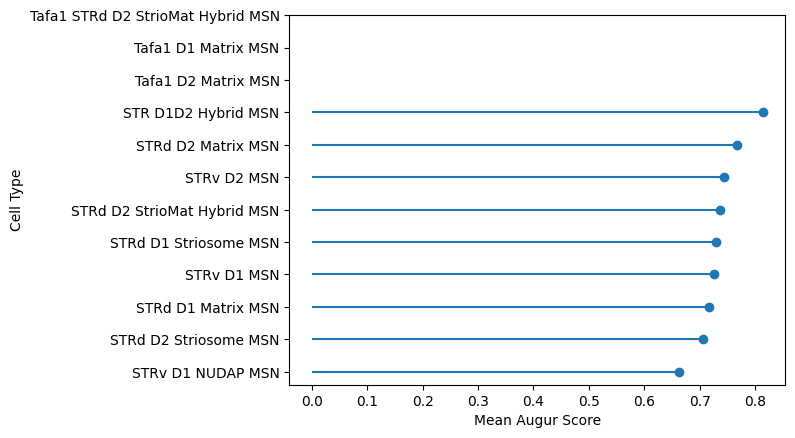

In [13]:
ranked_cts = v_results["summary_metrics"].T.sort_values('mean_augur_score', ascending=False)
print(ranked_cts)

augur.plot_lollipop(v_results)

In [ ]:
# 1. First, run AUGUR to prioritize
import pertpy as pt

augur = pt.tl.Augur("random_forest_classifier")

adata.obs["my_ct"] = adata.obs["Group_name"].astype(str) + adata.obs["zone"].astype(str)

loaded_data = augur.load(adata, label_col="state", cell_type_col="Group_name")

v_adata, v_results = augur.predict(
    loaded_data,
    n_threads=16
)

# Get cell types ranked by AUGUR score
ranked_cts = v_results["summary_metrics"].T.sort_values('mean_augur_score', ascending=False)
print(ranked_cts)

augur.plot_lollipop(v_results)

# 2. Focus DEG only on high-scoring cell types
TOP_N = 5  # Only analyze top 5 most affected
priority_cell_types = ranked_cts.head(TOP_N)['cell_type'].tolist()

! Set smaller span value in the case of a `segmentation fault` error.
! Set larger span in case of svddc or other near singularities error.


Output()

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

ckages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 54, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (6, 1), but need classifier with two classes.

  warnings.warn(
/home/gdallagl/myworkdir/XDP/.venv/lib/

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
          

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
          

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 54, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (7, 1), but need classifier with two classes.

  warnings.warn(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

   ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 54, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (6, 1), but need classifier with two classes.

  warnings.warn(
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-pa

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/sklearn/utils/_response.py", line 217, in _get_response_values
    y_pred = _process_predict_proba(
          

AttributeError: 'tuple' object has no attribute 'sort_values'

---
---
---

In [ ]:
# for ct in CELL_TYPES:
#     for zone in ZONES:

#         zone="5"

#         # Prepare for capturing figures
#         figures = []  # Store all figures here
#         # Save orinal show
#         original_show = plt.show
#         # Create dummy show that does nothing
#         def dummy_show(*args, **kwargs):
#             pass  # Do nothing - don't display or clear

#         # Replace show
#         plt.show = dummy_show

#         print(f"""
#                 #########################
#                 ### Processing cell type: {ct} | zone: {zone}
#                 #########################
#               """)

#         # Subset to current cimbination
#         adata_pb_tmp = adata_pb_all[(adata_pb_all.obs[CT_FOR_DEG_VARIABLE] == ct) & (adata_pb_all.obs[ZONE_VARIABLE] == zone)].copy()

#         #############################

#         # Filter sample/pesudocells

#         # Plot psuedocells
#         dc.pl.filter_samples(
#             adata=adata_pb_tmp,
#             groupby=[CONTRAST_VARIABLE, CT_FOR_DEG_VARIABLE, ZONE_VARIABLE],
#             min_cells=MIN_CELLS_PER_PSUDOCELL,
#             min_counts=MIN_COUNTS_PER_PSEUDOCELL,
#             figsize=(5, 5),
#         )
#         figures.append(plt.gcf())

#         # Filer bad pseudocells
#         dc.pp.filter_samples(adata_pb_tmp, min_cells=MIN_CELLS_PER_PSUDOCELL, min_counts=MIN_COUNTS_PER_PSEUDOCELL)

#         # Plot how many remainin
#         dc.pl.obsbar(adata=adata_pb_tmp, y=CT_FOR_DEG_VARIABLE, hue=CONTRAST_VARIABLE, figsize=(5, 2))
#         figures.append(plt.gcf())

#         # Stop if we dont have enoght sample per group
#         group_counts = adata_pb_tmp.obs[CONTRAST_VARIABLE].value_counts()
#         print(f"Samples per group: {dict(group_counts)}")

#         if any(group_counts < MIN_PSEUDOCELL_PER_GROUP):
#             print(f"   Insufficient samples: {dict(group_counts)}")
#             print(f"   Need ≥{MIN_PSEUDOCELL_PER_GROUP} per group. Skipping this combination.")
#             continue  # Skip this cell_type × zone

#         #############################

#         # Variance Exploration

#         # Store raw counts in layers
#         adata_pb_tmp.layers["counts"] = adata_pb_tmp.X.copy()
#         # Normalize, scale and compute pca
#         sc.pp.normalize_total(adata_pb_tmp, target_sum=1e4)
#         sc.pp.log1p(adata_pb_tmp)
#         sc.pp.scale(adata_pb_tmp, max_value=10)
#         sc.tl.pca(adata_pb_tmp)
#         # Return raw counts to X
#         dc.pp.swap_layer(adata=adata_pb_tmp, key="counts", inplace=True)

#         # one-way ANOVA --> Which PCA components are most strongly associated with differences between states
#         # High F-statistic / low p-value --> That PCA axis strongly separates healthy vs diseased.
#         dc.tl.rankby_obsm(adata_pb_tmp, key="X_pca", 
#                           obs_keys=[CONTRAST_VARIABLE]) # Only categoridal covariates
#         sc.pl.pca_variance_ratio(adata_pb_tmp)
#         figures.append(plt.gcf())
#         dc.pl.obsm(adata=adata_pb_tmp, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(5, 5))
#         figures.append(plt.gcf())

#         # PCA plot colored by state
#         sc.pl.pca(
#             adata_pb_tmp,
#             color=[SAMPLE_VARIABLE, CONTRAST_VARIABLE],
#             ncols=3,
#             size=300,
#             frameon=True,
#             components=["1,2"]
#         )
#         figures.append(plt.gcf())

#         # Gens drivin PC1
#         print("Top genes driving PC1:")
#         loadings = adata_pb_tmp.varm["PCs"]
#         pc1 = loadings[:, 0]
#         genes = adata_pb_tmp.var_names
#         df_pc1 = pd.DataFrame({
#             "gene": genes,
#             "loading": pc1
#         }).sort_values("loading", ascending=False)
#         #display(df_pc1)
#         figures.append(convert_df_to_fig(pd.concat([df_pc1[0:10], df_pc1[-10:]]), "PC1 gene loadings"))

#         #############################

#         # Filter noisy/low wxpressed genes (cell type level)

#         # Plot (not filter yet)
#             # genes in upper-rught quadrant are kept
#         dc.pl.filter_by_expr(
#             # TEST: A gene is kept if it 
#             #   - has at least "min_count" counts in at least "large_n" samples AND
#             #   - its total count across all samples is ≥ "min_total_count" AND
#             #   - is expressed in at least "min_prop" fraction of samples
#             adata=adata_pb_tmp,
#             group=CONTRAST_VARIABLE, # Column in obs defining biological groups (e.g. disease / condition)

#             min_count=MIN_COUNTS, 
#             large_n=LARGE_N, 
#             min_total_count=MIN_TOTAL_COUNTS, 

#             min_prop=MIN_PROP_BY_EXPR, # gene must be expressed in at least this fraction of samples
#         )
#         figures.append(plt.gcf())

#         # Plot (not filter yet)
#             # genes on the right are kept
#         dc.pl.filter_by_prop(
#             # TEST: A gene is kept if it
#             #   - is detected in ≥ "min_prop" of cells
#             #   - in at least "min_smpls" samples.
#             adata=adata_pb_tmp,
#             min_prop=MIN_PROP_BY_PROP,
#             min_smpls=MIN_SMPLS,
#         )
#         figures.append(plt.gcf())

#         # Apply filters
#         dc.pp.filter_by_expr(adata=adata_pb_tmp, group=CONTRAST_VARIABLE,min_count=MIN_COUNTS, large_n=LARGE_N, min_total_count=MIN_TOTAL_COUNTS, min_prop=MIN_PROP_BY_EXPR)
#         dc.pp.filter_by_prop(adata=adata_pb_tmp,min_prop=MIN_PROP_BY_PROP,min_smpls=MIN_SMPLS)

#         #print("After Gene filtering", adata_pb_tmp)


#         #############################

#         # Check Multi-collinaarty covariates

#         # Extract covariate data
#         df = adata_pb_tmp.obs[COVARIATES_FOR_DEG].copy()
        
#         # Calculate correlation matrix (Pearson by default)
#         corr_matrix = df.corr()
        
#         # Create plot
#         fig, ax = plt.subplots(figsize=(8, 6))
        
#         # Heatmap with annotations
#         sns.heatmap(
#             corr_matrix,
#             annot=True,           # Show correlation values
#             fmt='.2f',            # 2 decimal places
#             cmap='coolwarm',      # Red=positive, Blue=negative
#             vmin=-1, vmax=1,      # Correlation range
#             center=0,             # Center colormap at 0
#             square=True,          # Square cells
#             cbar_kws={'label': 'Pearson Correlation'},
#             ax=ax
#         )
        
#         plt.title('Covariate Correlations', fontsize=14, pad=20)
#         plt.tight_layout()

#         figures.append(fig)

#         #############################

#         # Perform DEG: PyDeseq2

#         # Build design formula as string
#         design_formula = f"~ {CONTRAST_VARIABLE}"
#         if COVARIATES_FOR_DEG:
#             design_formula += " + " + " + ".join(COVARIATES_FOR_DEG)
#         print(f"\nDesign formula: {design_formula}\n")
        
#         try:

#             # Create DESeq2 dataset
#                 # validate inputs
#                 # convert cateogicla to dummy
#                 # ...
#             dds = DeseqDataSet(
#                 adata=adata_pb_tmp, # .X must be raw counts
#                 #design_factors=design_factors, # varibales to use in the model formula. ATTENTION: first is the varible of interest
#                 design = design_formula, # if want to specifiy direclty design
#                 ref_level=[CONTRAST_VARIABLE, CONTRAST_BASELINE],  # defines which level of your factor is the “baseline” in the statistical model --> facotr name, referece level
#                     # if healthy is the reference, --> log2FC=diseased−healthy
#                 refit_cooks=True, # Refit model excluding outlier samples
#                 n_cpus=None, # Each gene processed independently --> cna aprallelise
#                 # quiet=True,
#                 # low_memory=True
#             )
            
#             # Run DESeq2 pipeline --> Compute LFCs and p-values
#                 # estimate size facotr (median of rations)
#                 # estimate gene wise dispersions 
#                 # fit a spline in dispetiosn
#                 # perform gene wise dispersion shrinkage (bayes shorinakge)
#                 # fit ngeative binomila GLM
#                 # refir cook outliers
#             dds.deseq2() # modifies in place
            
#             # Extracts results for ONE specific comparison
#                 # Ectartc specific constarts
#                 # prepare for stat test  --> no stst test in here
#             stats = DeseqStats(
#                 dds,
#                 contrast=[CONTRAST_VARIABLE, CONTRAST_STIM, CONTRAST_BASELINE], 
#                     #list of 3: "E.g., ['condition', 'B', 'A'] will measure the LFC of 'condition B' compared to 'condition A'."
#                 alpha=ALPHA_MULTIPLE_TEST, #FDR threshold for significance calls
#                 n_cpus=None,
#                 #cooks_filter=True # true is better
#                 # independent_filter = True # Ttue is better
#             )

#             # Runs statistical analysis 
#                 # LFC Shrinkage --> improves LFC accuracy for low-count genes
#                 # Independent filtering  --> increases power by removing low-count genes
#                 # run Wald tests znd get pvlaues
#                 # perform mutliple stets corretcion (benjamini)
#                 # create reuslt table
#             stats.summary()

#             # Extract results
#             results_df = stats.results_df

#             # Save full results
#             output_file = f'{SAVE_FOLDER}/{ct}_zone{zone}.csv'
#             stats.results_df.to_csv(output_file)

#             # Culacno plot
#             dc.pl.volcano(results_df, x="log2FoldChange", y="padj")
#             figures.append(plt.gcf())

#             # MA plot (better than volcano for DESeq2)
#             plt.figure(figsize=(8, 6))
#             plt.scatter(results_df['baseMean'], results_df['log2FoldChange'], 
#                         c=(results_df['padj'] < 0.05), alpha=0.5, s=1)
#             plt.xscale('log')
#             plt.xlabel('Mean Expression')
#             plt.ylabel('Log2 Fold Change')
#             plt.title('MA Plot')
#             figures.append(plt.gcf())

#             # Heatmap
#             sc.pl.heatmap(adata_pb_tmp, var_names=, groupby=CONTRAST_VARIABLE)

#             # Filter results
#             results_df_sig = results_df[
#                 (results_df.padj <= ALPHA_MULTIPLE_TEST) &
#                 (np.abs(results_df.log2FoldChange)) >= 0.5
#             ].sort_values(by="log2FoldChange", ascending=False)
#             print("Deseq2 Significant")
#             display(results_df_sig)
#             dc.pl.volcano(results_df, x="log2FoldChange", y="padj"); plt.show()
#             figures.append(convert_df_to_fig(pd.concat([results_df_sig[0:10], results_df_sig[-10:]])[["log2FoldChange", "padj"]], "Deseq2 Results Filtered"))


#             #############################

#             # Save PDF
#             from matplotlib.backends.backend_pdf import PdfPages

#             with PdfPages(f'{SAVE_FOLDER}/{ct}_zone{zone}.pdf') as pdf:
#                 for fig in figures:
#                     pdf.savefig(fig, bbox_inches='tight')
#                     plt.close(fig)

#             figures

#         except Exception as e:
#             print(f"❌ DESeq2 failed: {e}")

#         finally:
#             # Report oringla show
#             plt.show = original_show







#         ###################
#         ###################
#         ### EdgeR
#         ###################
#         ###################

#         edger_results = DEG.run_edger_analysis(
#             adata_pb=adata_pb_tmp,
#             contrast_variable=CONTRAST_VARIABLE,
#             contrast_test=CONTRAST_STIM,
#             contrast_baseline=CONTRAST_BASELINE,
#             covariates=COVARIATES_FOR_DEG,
#             alpha=ALPHA_MULTIPLE_TEST,
#             lfc_threshold=0.5,
#         )
        
#         if edger_results is None:
#             print("❌ Analysis failed, skipping...")
#             continue

#         # # Save results
#         # results['results_df'].to_csv(
#         #     f'results/edger_{ct}_zone{zone}_all.csv', 
#         #     index=False
#         # )

#         print("Deseq2 Significant")
#         display(edger_results["sig_results"])
#         dc.pl.volcano(edger_results["results_df"], x="log2FoldChange", y="padj"); plt.show()

#         break
#     break

----
---

# Moran SVGs

In [ ]:
#d = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/diseased/recon_241105/adata/all_lib_adata_zoned.h5ad", backed="r")
d = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/diseased/sample_01/adata/all_lib_adata_zoned.h5ad", backed="r")

print(d)

MSN_names = ["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRv D1 NUDAP MSN",
             "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN",
             "STR D1D2 Hybrid MSN",
             "Tafa1 STRd D1 Matrix MSN", "Tafa1 STRd D2 Matrix MSN", "Tafa1 STRd D2 StrioMat Hybrid MSN"]


d = d[(d.obs.has_spatial)]#& (d.obs.Group_name.isin(MSN_names))]
# = d[d.obs.Neighborhood_name=="Subpallium GABA"]

d = d.to_memory()

sc.pl.embedding(d, basis="spatial", color="Group_name")


In [ ]:
sc.pl.embedding(d, basis="spatial", color="Subclass_name")

In [ ]:
for ct in ["Oligo OPALIN"]: #"STR D1D2 Hybrid MSN"]:#d.obs.Group_name.unique().tolist():

    print(ct)

    d_tmp=d[d.obs.Group_name == ct].copy()

    d_tmp.X = d_tmp.layers["log1p_norm"].copy()

    import squidpy as sq 
    sq.gr.spatial_neighbors(d_tmp, coord_type="generic", n_neighs=10) #Builds a spatial neighbor graph
    sq.gr.spatial_autocorr(d_tmp, mode="moran", genes=d.var_names) #Computes Moran’s I spatial autocorrelation statistic for each gene.

    res = d_tmp.uns["moranI"]

    svg = res[res["pval_norm_fdr_bh"] < 0.05] \
            .sort_values("I", ascending=False)

    top_genes = svg.sort_values("I", ascending=False).index[0:20]
    display(svg.head(20))
    print(top_genes)

    for g in top_genes:
        sc.pl.embedding(d_tmp, basis="spatial", color=g, 
                        size=50, cmap="viridis", 
                        title=f"{g} (Moran's I = {svg.loc[g, 'I']:.3f})")
        plt.show()

In [ ]:
a = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/D2_mat_QC_1.h5ad")#, backed="r")

from scipy import sparse
import scanpy as sc

adata_minimal = sc.AnnData(
    X=sparse.csr_matrix(a.X),
    obs=a.obs.copy(),
    var=a.var.copy()
)

adata_minimal = adata_minimal[~ adata_minimal.obs["Final_Zone_Assignments_v2"].isna()]

adata_minimal.write("/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/STR_D2_Matrix_MSN.h5ad")

In [ ]:
from scipy import sparse
import scanpy as sc

a = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/STR_D1_Matrix_MSN.h5ad")#, backed="r")


git clone https://github.com/zhoux85/STAligner.git
cd STAligner


pyenv install 3.8.18
pyenv virtualenv 3.8.18 env_STAligner
pyenv activate env_STAligner

# depends on nvidia-smi CUDA versio
pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

# Get the exact PyTorch version
TORCH_VERSION=$(python -c "import torch; print(torch.__version__)" | cut -d+ -f1)
CUDA_VERSION="cu121"
echo "Installing PyG for PyTorch ${TORCH_VERSION} with ${CUDA_VERSION}"

pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH_VERSION}+${CUDA_VERSION}.html
pip install torch-geometric

# Remvoe torch from requiremt.txt
cat requirement.txt | grep -v "torch" > requirement_filtered.txt

pip install -r requirement_filtered.txt

# Install STAligner
python setup.py build
python setup.py install



---

In [ ]:
# df = pd.read_csv("/home/gdallagl/myworkdir/XDP/utils/dorsal_ventral_gradient/exp_by_spline_combined.csv")
# df = df[(np.abs(df.mean_spearman) >= 0.3) & (df.combined_p <= 0.05)].sort_values("mean_spearman")
# print(df.shape)
# df.to_csv("/home/gdallagl/myworkdir/XDP/utils/dorsal_ventral_gradient/exp_by_spline_combined_corr>0.3.csv")